# RNN for Develope LSTM
## Contents
1. Vanilla RNN
    - 정의
    - 종류
    - RNN의 연산(Language Model)
    - RNN의 단점
2. LSTM(Long Short Term Memory)
    - 정의
    - LSTM 연산
    - LSTM의 Loss와 Back Probagation
3. LSTM 구현하기

## 1-1. Vanilla RNN 정의

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.dropbox.com/s/g56om5s3vt62pyx/Screenshot%202018-05-27%2021.31.06.png?raw=1", width = 900, height = 500)
# print('\t그림1. Vanila RNN의 표현')

그림1. Vanila RNN의 표현

### 정의  
- 각각 이전 cell의 Hidden state $(h_{t-1})$ 와 입력 값$(x_t)$ 을 처리하는 $W_{hh}$ 와 $W_{xh}$를 공유하는 신경망 구조.  
- 출력 값을 $y$는 출력 값을 생성하는 층의 Weight Matrix $W_{hy}$와 연산을 통해 값을 예측
       
### 특징
- 정의와 같이 RNN 신경망은 가중치를 공유하는 특성을 갖고 있어, 시계열 데이터(자연어, 동영상)와 같은 데이터를 처리하는데 우수한 성능을 보임  
- RNN은 입력 및 출력 시퀀스에 대해 제약이 없음
       
       
※ 이때 tanh를 activatioin function으로 사용하는 이유  
- [sigmoid에 비해 tanh가 그레이디언트 소실(Gradient Vanishing) 문제에 비교적 효과적 대안으로 여겨짐](https://brightwon.tistory.com/10)

## 1-2. RNN의 종류

In [ ]:
Image(url= "https://www.dropbox.com/s/5lvfnk3ahvyarmc/Screenshot%202018-05-27%2020.36.58.png?raw=1", width = 1100, height = 400)

그림 2. RNN의 이용에 따른 종류  
### RNN의 입력 출력에 따른 종류  
(RNN은 시퀀스 길이에 상관없이 입력을 받고, 출력을 생성할 수 있음)
1. one-to-one : ??
2. one-to-many : Image Caption(자막 생성)
3. many-to-one : sentiment analysis(감성 분석)
4. many-to-many(1) : Machine Translation(기계 번역)
5. many-to-many(2) : Sequence Labelling(Pos-Tagging, NER)

## 1-3. RNN의 연산

In [ ]:
Image(url= "https://www.dropbox.com/s/3vh3et9gdfe4yai/Screenshot%202018-05-27%2021.44.49.png?raw=1", width = 800, height = 400)

그림 3. RNN의 연산(Many-to-Many)  
#### RNN의 연산(Many-to-Many)  
- RNN의 내부 가중치인 Weight Matrix $W$는 모든 time-step에서 동일함
- t번째 결과인 $y_t$를 통해 각 time-step의 loss를 계산 할 수 있음.
- 각 time-step의 모든 loss($L_t$)를 더한 Loss($L$)가 전체 모델의 Loss  

In [ ]:
Image(url= "https://www.dropbox.com/s/v06pglkpd24d865/Screenshot%202018-05-27%2021.45.03.png?raw=1", width = 800, height = 400)

그림 4. RNN의 연산(Many-to-One)
#### RNN의 연산(Many-to-one)
- RNN의 내부 가중치인 Weight Matrix $W$는 모든 time-step에서 동일함
- 마지막 time-step의 결과인 $y_t$의 Loss를 사용해 Loss계산

In [18]:
Image(url= "http://i.imgur.com/XYDxsNs.png", width = 800, height = 400)

그림 5. RNN 모델의 역전파 그림  
RNN의 역전파(Backpropagation Trough Time)
- RNN의 역전파는 시간에 역순으로 진행함
- RNN의 역전파 과정은 긴 Sequence에 대해 너무 연산시간이 너무 길기 때문에, 가장 끝으로 부터 n번째까지의 output에 대해서 역전파 되는 값을 고려하기도 함

## 1-4 RNN의 단점
### RNN의 단점
1. Gradient Explsion
2. Gradient Vanishing


$$\frac{dE_3}{dW}=\sum_k^n\frac{dE_n}{d\hat{y_n}}\frac{d\hat{y_3}}{dh_3}(\prod_{j=k+1}^n{\frac{dh_j}{d_{j-1}}})\frac{dh_k}{dW}$$  
이떄, $\prod_{j=k+1}^n{\frac{dh_j}{d_{j-1}}}$에 의해 Gradient가 계속 해서 다음 time-step에 전달 되면서 그 값에따라 Gradient가 무한히 커질수도 있고(Gradient Explosion) 무한히 작아져 0에 수렴할 수도 있다(Gradient Vanishing).

#### 해결 방법
- Gradient Explosion : Gradient전달 과정에서 값을 K 미만으로 고정하여 전달하는 값을 조절하는 방법 Gradient Clipping
- Gradient Vanishing : LSTM!! 하지만 완벽한 대안은 아니다.

## LSTM 구현 - 데이터 준비

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 
## shakespeare corpus 다운로드
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# char --> number로 변환 하기 위한 dictionary 정의
char2idx = {char : i for i, char in enumerate(sorted(set(text)))}
idx2char = {i : char for i, char in enumerate(sorted(set(text)))}


## 정수 인코딩

In [4]:
# \n 제거
data = [char2idx[char] for char in text if char != '\n']
inputs = data[:-1]
outputs = data[1:]

In [5]:
print(inputs[:10])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47]


In [6]:
# 각 문장(대사) 단위로 split
text = text.split('\n\n')
# 각 문장의 음절 토큰을 정수 인코딩
data = np.array([np.array([char2idx[char]  for char in ' '.join(sentence.split('\n'))]) for sentence in text])

In [7]:
print('input : ',''.join([idx2char[i] for i in inputs[:25]]))
print('output : ', ''.join([idx2char[i] for i in outputs[:25]]))

input :  First Citizen:Before we p
output :  irst Citizen:Before we pr


## LSTM 구현 - 모델
- 활성함수 정의

In [8]:
def sigmoid(x, backpropagation = False):
  output = 1/(1 + np.exp(-x))
  if backpropagation:
    return output*(1-output)
  return output
  
def tanh(x,backpropagation = False):
  output = (1-np.exp(-x))/(1+np.exp(-x))
  if backpropagation:
    return 1-output**2
  return output

def softmax(x):
  output = np.exp(x)/np.sum(np.exp(x))
  return output

In [9]:
Image(url= "https://www.dropbox.com/s/ufx6fm508mieoiz/Screenshot%202018-05-28%2017.09.54.png?raw=1", width = 800, height = 350)

가중치 행렬 정의 및 forward함수 정의

In [10]:
def forward(x, h, c, predict_all_sequences = True):
#     print(x.shape)
#     x = np.expand_dims(x, axis = -1)
    tmp = np.dot(W_xh, x) + np.dot(W_hh, h) + bh
    f_t = sigmoid(tmp[ :hidden_size])
    i_t = sigmoid(tmp[hidden_size : hidden_size*2])
    o_t = sigmoid(tmp[hidden_size*2 : hidden_size*3])
    g_t = tanh(tmp[hidden_size*3 : ])
#     print(f_t.shape, i_t.shape, c.shape, g_t.shape)
    c_t = f_t*c + i_t*g_t
    h_t = o_t*tanh(c_t)
    if predict_all_sequences : 
        return softmax(np.dot(W_h_y,h_t) + b_y), f_t, i_t, o_t, g_t, h_t, c_t
    return h_t

def categorical_crossentropy(pred, y):
    return -np.log(pred[y,0])



Loss function 정의

In [ ]:
Image(url= "http://i.imgur.com/XYDxsNs.png", width = 800, height = 500)

In [11]:
def lossFun(inputs, targets, hprev, cprev):
    xs, hs, cs, is_, fs, os, gs, ys, ps = {}, {}, {}, {}, {}, {}, {}, {}, {}
    # t = 0 일때 입력 hidden state, cell state 정의
    hs[-1] = np.copy(hprev)
    cs[-1] = np.copy(cprev)
    loss = 0
    H = hidden_size
    # loss 계산을 하기위한 forward연산
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size, 1))  # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        tmp = np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + bh  # hidden state
        '''
          input gate, forget gate, gate gate, cell state, hidden state 정의
        '''
        is_[t] = sigmoid(tmp[:H])
        fs[t] = sigmoid(tmp[H:2 * H])
        os[t] = sigmoid(tmp[2 * H: 3 * H])
        gs[t] = np.tanh(tmp[3 * H:])
        cs[t] = fs[t] * cs[t-1] + is_[t] * gs[t]
        hs[t] = os[t] * np.tanh(cs[t])
        ys[t] = np.dot(Why, hs[t]) + by 
        # softmax function
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += categorical_crossentropy(ps[t],targets[t])
    # 역전파 계산을 위한 변수 설정
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext, dcnext = np.zeros_like(hs[0]), np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1  #  y 미분값 계산
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # h의 미분값 계산
        dc = dcnext + (1 - np.tanh(cs[t]) * np.tanh(cs[t])) * dh * os[t]  # tanh에 대한 미분값 계산
        dcnext = dc * fs[t]
        di = dc * gs[t]
        df = dc * cs[t-1]
        do = dh * np.tanh(cs[t])
        dg = dc * is_[t]
        ddi = (1 - is_[t]) * is_[t] * di # tanh 미분값 계산
        ddf = (1 - fs[t]) * fs[t] * df # tanh 미분값 계산
        ddo = (1 - os[t]) * os[t] * do # tanh 미분값 계산
        ddg = (1 - np.tanh(gs[t]) * np.tanh(gs[t])) * dg # tanh 미분값 계산
        da = np.hstack((ddi.ravel(),ddf.ravel(),ddo.ravel(),ddg.ravel()))
        dWxh += np.dot(da[:,np.newaxis],xs[t].T)
        dWhh += np.dot(da[:,np.newaxis],hs[t-1].T)
        dbh += da[:, np.newaxis]
        dhnext = np.dot(Whh.T, da[:, np.newaxis])
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)  # Gradient clipping
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs) - 1], cs[len(inputs) - 1]

In [12]:
def sample(prevh, prevc, seed_ix, n):
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    c = prevc
    h = prevh
    H = hidden_size
    for t in range(n):
        tmp = np.dot(Wxh, x) + np.dot(Whh, h) + bh  # 가중치 행렬을 통한 hidden state 계산
        i = sigmoid(tmp[:H])
        f = sigmoid(tmp[H:2 * H])
        o = sigmoid(tmp[2 * H: 3 * H])
        g = np.tanh(tmp[3 * H:])
        # gate값 분할
        c = f * c + i * g
        h = o * np.tanh(c)
        y = np.dot(Why, h) + by 
        # softmax 수행
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        # 단어 예측
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

In [13]:
hidden_size = 100  # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for / 한번에 처리할 문자 개수
learning_rate = 1e-1
vocab_size = len(char2idx)
# 가중치 정의
Wxh = np.random.randn(4 * hidden_size, vocab_size) * 0.01  
Whh = np.random.randn(4 * hidden_size, hidden_size) * 0.01 
Why = np.random.randn(vocab_size, hidden_size) * 0.01  
bh = np.zeros((4 * hidden_size, 1))  
by = np.zeros((vocab_size, 1))  
loss_list = []
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)  
smooth_loss = -np.log(1.0 / vocab_size) * seq_length 
while n < 1000001:
    # Epoch가 시작이 되면 RNN값 초기화
    if p + seq_length + 1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size, 1))  # RNN 값 초기화
        cprev = np.zeros((hidden_size, 1))
        p = 0  # go from start of data
    input = [ch for ch in inputs[p:p + seq_length]] # 25글자씩을 index로 바꿈
    target = [ch for ch in outputs[p + 1:p + seq_length + 1]] # 바로 다음 글자가 target이 됨

    # 10000번마다 예측
    if n % 10000 == 0:
        sample_ix = sample(hprev, cprev, inputs[0], 100)
        txt = ''.join(idx2char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt,))

    # loss 및 역전파를 통한 각 가중치의 미분값 계산
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev, cprev = lossFun(input, target, hprev, cprev)
    loss_list.append(loss)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 10000 == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # Adagrad를 통한 weight 갱신
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

    p += seq_length
    n += 1 

----
 UPdR:TF&CzRXHW FFyOTVTsU!VOdv!BmpwCYCv'F;IlVYZvFQSrfhe;ti:jjtAKGN Ct
vqc Pkm
Pcd'Zlt?ySaHxKAo, LHGDu 
----
iter 0, loss: 104.359681
----
 rstCius!eUt eoy'.Frst:t nsedbgt odcknt eToe.iNsU,Frs o e;bnwteeoT e ir u aaiyuadyl,h sree sstoes-rut 
----
iter 10000, loss: 31.392290
----
 r hsrwyl,tyu usfo usn ir
cnefisc,ieeSu:mie ortemlyba hlnfrcnt fyse!e u.ih catnter d ees csitt akiyuu 
----
iter 20000, loss: 20.277315
----
 ssg oetfrliv d ik e orsrlfo hvrsyu o o hreiyso e bd pthn orMmet;l;slatyh u ntera,nc ua oy wa iyhrvrs 
----
iter 30000, loss: 16.159469
----
 ys hmnw,dl o hsl inehah rsesesai s;rmlgeTot t but ntusrcrpt a ademv.ethrh a aciv ei i,pru,ees ad ort 
----
iter 40000, loss: 14.921582
----
 r t il ett evygs h ade orm asytyMiN fbit i wieAyik edwrsec setoh asemp,tisihs neeoy u o hal onha,ert 
----
iter 50000, loss: 14.354012
----
 rit sadirs as npathasyS,hi or rvrni;amscevnehmm o o odmri;t peeig ui ha hc rvgtrcutv eatl' ha eesmot 
----
iter 60000, loss: 14.713169
----
 dsyht asn 

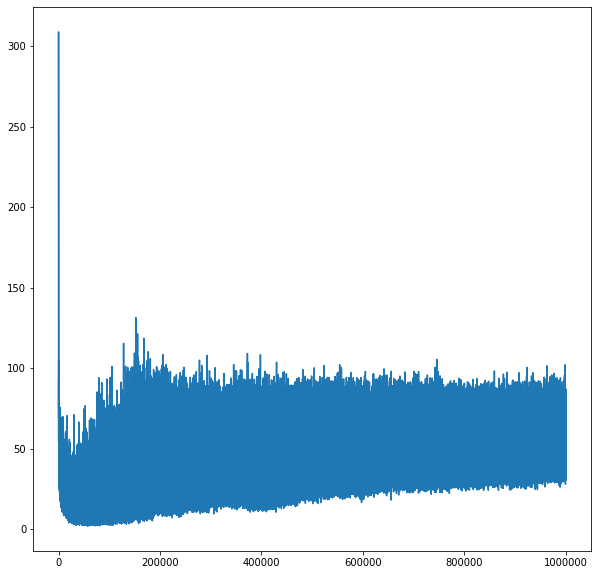

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.plot(loss_list)
plt.show()

## Reference
1. https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
2. [기계학습] 오일석. 2018
3. https://github.com/ratsgo/models/tree/master/LSTM_numpy
4. cs231n lecture 10. https://www.youtube.com/watch?v=6niqTuYFZLQ